**This notebook is aimed to produce a mock image using GalSim, and check if tractor subtraction + binary mask method can reproduce the given type of light profile.**

In [78]:
import os
import copy
import glob
import subprocess

import numpy as np

import sep

import matplotlib.pyplot as plt
from matplotlib import rcParams

from astropy.table import Table, Column, vstack
from astropy.io import fits
from astropy import wcs

from kungpao import imtools
from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

rcParams['figure.figsize'] = [10., 8.]
plt.rc('text', usetex=True)
%matplotlib inline

## Generate Mock Image

In [2]:
pixel_scale = 0.168

### Import field HSC backgroud



In [3]:
field = fits.open('cutout-HSC-R-9463-s18a_wide-181105-233414.fits')[1]
fld_img = field.data
w = wcs.WCS(field)

In [4]:
imtools.img_cutout(fld_img, w, 500, 500, pixel_unit=True, size=[1000,1000], prefix='field')

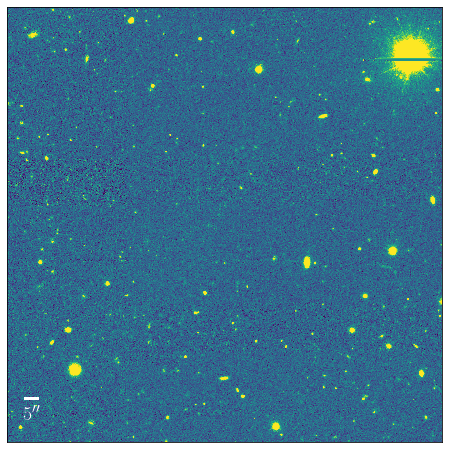

In [5]:
field = fits.open('field.fits')[0]
fld_img = field.data
w = wcs.WCS(field)
_ = display_single(fld_img)

In [6]:
b = 40  # Box size
f = 4   # Filter width
data = fld_img.byteswap().newbyteorder()
bkg = sep.Background(data, bw=b, bh=b, fw=f, fh=f)

In [7]:
bkg.globalrms

0.06547097861766815

### Make a sersic galaxy using `GalSim`
- Make sersic galaxy
- Backgroud sky value
- Gaussian Noise
- PSF = 0.7 arcsec Moffat
- Convolve
- drawIMAGE, size = [1000,1000]

In [8]:
import galsim

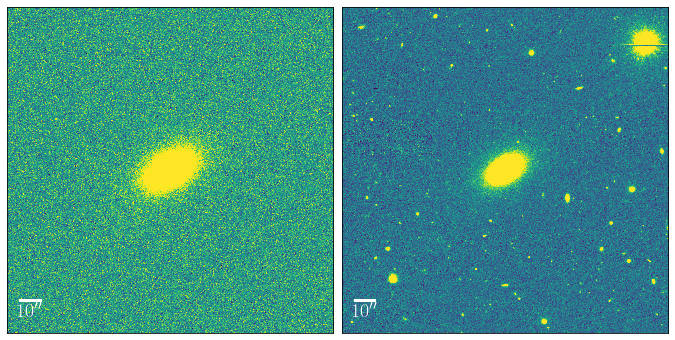

In [9]:
gal_flux = 1.e5   # total counts on the image
gal_rh = 1.       # arcsec
gal_q = 0.6       # b/a
sersic_index = 5
gal_beta = 30.    # degrees
psf_beta = 5
psf_rh = 0.7       # arcsec
noise = 2.        # standard deviation of the counts in each pixel

# Define sersic galaxy
gal = galsim.Sersic(sersic_index, half_light_radius=gal_rh, flux=gal_flux)

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)

gal_shape = galsim.Shear(q=gal_q, beta=gal_beta*galsim.degrees)
gal = gal.shear(gal_shape)

# Define the PSF profile
psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_rh)
#psf = galsim.Gaussian(half_light_radius=psf_rh, flux=1.)
# Convolve galaxy with PSF
final = galsim.Convolve([gal, psf])

# Draw the image with a particular pixel scale.
image = final.drawImage(scale=pixel_scale, nx=1000, ny=1000)

# Add noise
random_seed = 1534225
rng = galsim.BaseDeviate(random_seed+1)
#noise = galsim.PoissonNoise(rng, sky_level=1e-7)
noise = galsim.GaussianNoise(sigma=bkg.globalrms)
image.addNoise(noise) 

# Generate mock image
mock_img = image.array + fld_img

# Plot fake galaxy and the composite mock image
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
display_single(image.array, ax=ax1, scale_bar_length=10)
display_single(mock_img, scale_bar_length=10, ax=ax2)
plt.subplots_adjust(wspace=0.)

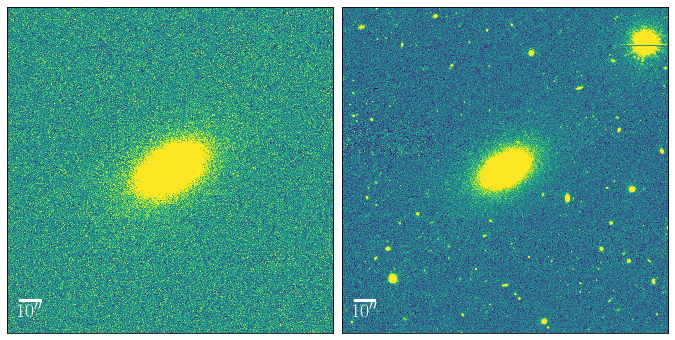

In [166]:
'''
gal_flux = 1.e5   # total counts on the image
gal_rh = 1.       # arcsec
gal_q = 0.6       # b/a
gal_beta = 30.    # degrees
psf_beta = 5
psf_rh = 0.7       # arcsec
noise = 2.        # standard deviation of the counts in each pixel

bulge_n = 3
bulge_rh = 1.
disk_n = 5
disk_rh = 3.
bulge_frac = 0.3

# Define sersic galaxy
bulge = galsim.Sersic(bulge_n, half_light_radius=bulge_rh)
disk = galsim.Sersic(disk_n, half_light_radius=disk_rh)
gal = bulge_frac * bulge + (1-bulge_frac) * disk
gal = gal.withFlux(gal_flux)
# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)

gal_shape = galsim.Shear(q=gal_q, beta=gal_beta*galsim.degrees)
gal = gal.shear(gal_shape)

# Define the PSF profile
psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_rh)
#psf = galsim.Gaussian(half_light_radius=psf_rh, flux=1.)
# Convolve galaxy with PSF
final = galsim.Convolve([gal, psf])

# Draw the image with a particular pixel scale.
image = final.drawImage(scale=pixel_scale, nx=1000, ny=1000)
noise = galsim.GaussianNoise(sigma=bkg.globalrms)
image.addNoise(noise) 


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
display_single(image.array, ax=ax1, scale_bar_length=10)
display_single(image.array + fld_img, scale_bar_length=10, ax=ax2)
plt.subplots_adjust(wspace=0.)
'''

In [10]:
_ = io.save_to_fits(mock_img, 'mock_img.fits')

## Run `Tractor` for the mock image

In [11]:
from tractor import NullWCS, NullPhotoCal, ConstantSky
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

### Download DECaLS catalogs which have overlap with this mock image

In [28]:
cen = mock_img.shape[0]
ra_cen, dec_cen = w.wcs_pix2world([[cen, cen]],1)[0]
dec_cen = -1.47
ra = '{:04}'.format(int(10*ra_cen))
dec = '{:03}'.format(int(abs(dec_cen)))
if dec_cen > 0:
    dec = 'p' + dec
else:
    dec = 'm' + dec
ra ,dec

('3513', 'm001')

In [ ]:
url = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/tractor/3/tractor-3500m052.fits'

In [ ]:
urllib.request.urlretrieve(
        obj['url'],
        filename=path + 'Cutout/z_0203/' + 'HSC-cutout-ra=' + str(round(obj['ra'], 2)) +
        '&dec=' + str(round(obj['dec'])) + '&band=HSC-r.fits')

In [ ]:
############# How to download files automatically???? ###########

In [13]:
url1 = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/tractor/351/tractor-3513p000.fits'
url2 = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/tractor/351/tractor-3513m002.fits'

import urllib
urllib.request.urlretrieve(url1, filename='./tractor-3513p000.fits')
urllib.request.urlretrieve(url2, filename='./tractor-3513m002.fits')

In [76]:
cat1 = Table.read('tractor-3513m002.fits', format='fits')
cat2 = Table.read('tractor-3513p000.fits', format='fits')
decals_catalog = vstack([cat1, cat2])
decals_catalog.write('DECaLS_catalog.fits', format='fits')

### Download PSF model from HSC

In [33]:
def gen_psf_url(ra, dec, band):
    return ['https://hscdata.mtk.nao.ac.jp/psf/6/cgi/getpsf?ra='
       + str(ra) 
       + '&dec='
       + str(dec)
       + '&filter='
       + str(band.lower())
       + '&rerun=s18a_wide&type=coadd&centered=on']

In [43]:
# Import HSC username and password
config = Table.read('./HSC_config', format='ascii.no_header')['col1']
username = config[0]
password = config[1]

In [51]:
# Create a password manager
password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()

# Add the username and password.
# If we knew the realm, we could use it instead of None.
top_level_url = 'https://hscdata.mtk.nao.ac.jp/'

password_mgr.add_password(None, top_level_url, username, password)

handler = urllib.request.HTTPBasicAuthHandler(password_mgr)

# create "opener" (OpenerDirector instance)
opener = urllib.request.build_opener(handler)

# use the opener to fetch a URL
opener.open(top_level_url)

# Install the opener.
# Now all calls to urllib.request.urlopen use our opener.
urllib.request.install_opener(opener)

In [53]:
# Download PSF file from HSC server, and save it as 'PSF_model.fits'
urllib.request.urlretrieve(gen_psf_url(35.1230, -3.234, 'r')[0], filename='./PSF_model.fits')

('./PSF_model.fits', <http.client.HTTPMessage at 0x129b5e898>)

### Import mock images and PSF model

In [181]:
pixel_scale = 0.168 # arcsec/pixel

# Import image data
img = fits.open('mock_img.fits')[0]
img_data = img.data
field = fits.open('field.fits')[0]
w = wcs.WCS(field)


# Import HSC PSF data
psf_data = fits.open('PSF_model.fits')[0].data
psf_obj = PixelizedPSF(psf_data, Lorder=3)

# Change the byteorder (translate the bytes)
img_data = img_data.byteswap().newbyteorder()

In [182]:
cen = img.data.shape[0]/2  # Central position of the image
print ('Size (in pixel):', [cen*2, cen*2])
print ('Angular size (in arcsec):', [cen*2*pixel_scale, cen*2*pixel_scale])
print ('The center of this image:', [cen, cen])

Size (in pixel): [1000.0, 1000.0]
Angular size (in arcsec): [168.0, 168.0]
The center of this image: [500.0, 500.0]


In [183]:
# Estimate background and fluctuation
b = 50  # Box size
f = 5   # Filter width
bkg = sep.Background(img_data, bw=b, bh=b, fw=f, fh=f)
data_sub = img_data - bkg.globalback

# Calculate invvar of image
invvar_data = 1.0/(bkg.rms()**2.0)

# Extract objects
obj_hthre, seg_hthre = sep.extract(data_sub, 5.0,
                                   err=bkg.globalrms, 
                                   minarea=5, 
                                   deblend_nthresh=10, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

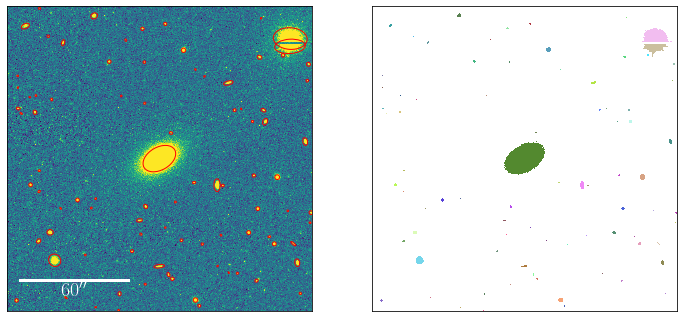

In [57]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(1,2, figsize=(12,6))
display_single(img_data, ax=ax[0], scale_bar_length=60, pixel_scale=pixel_scale)

# plot an ellipse for each object
for obj in obj_hthre:
    e = Ellipse(xy=(obj['x'], obj['y']),
                width=8*obj['a'],
                height=8*obj['b'],
                angle=obj['theta']*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)
    
display_single(seg_hthre, scale='linear', cmap=SEG_CMAP , ax=ax[1])

In [58]:
### 想个办法把亮星自动mask掉

In [66]:
seg_hthre[860, 926]

79

In [69]:
seg_fake = copy.deepcopy(seg_hthre)
seg_fake[np.logical_and.reduce([seg_fake!=79, seg_fake!=83])] = 0
seg_fake[seg_fake!=0]=1

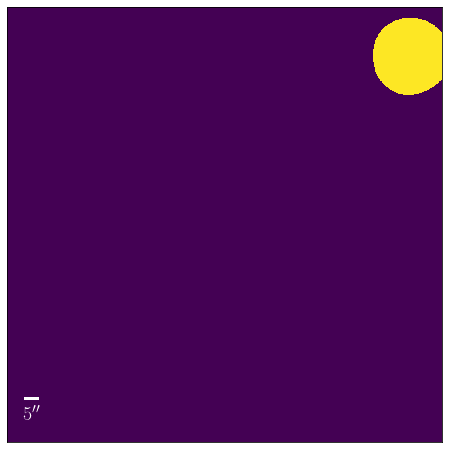

In [70]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
seg_conv = copy.deepcopy(seg_fake)
# Convolve the image with a Gaussian kernel with the width of 5 pixel
# This is actually pretty slow, because the image is very large. 
seg_conv = convolve(seg_conv.astype('float'), Gaussian2DKernel(20.0))
star_mask = seg_conv >= 0.005

_ = display_single(star_mask.astype(int), scale='linear')

In [71]:
img_masked = copy.deepcopy(data_sub)
img_masked[star_mask]=0
obj_hthre, seg_hthre = sep.extract(img_masked, 5.0,
                                   err=bkg.globalrms, 
                                   minarea=5, 
                                   deblend_nthresh=10, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

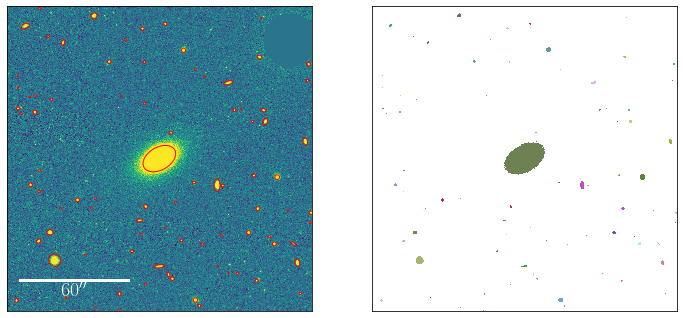

In [72]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(1,2, figsize=(12,6))
display_single(img_masked, ax=ax[0], scale_bar_length=60, pixel_scale=pixel_scale)

# plot an ellipse for each object
for obj in obj_hthre:
    e = Ellipse(xy=(obj['x'], obj['y']),
                width=8*obj['a'],
                height=8*obj['b'],
                angle=obj['theta']*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)
    
display_single(seg_hthre, scale='linear', cmap=SEG_CMAP , ax=ax[1])

### Save our measurements to a file

In [75]:
obj_table, seg_data = obj_hthre, seg_hthre

img_wcs = w

#get the arcsec length of major/minor axes
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b']) 

x = obj_table['x']
y = obj_table['y']
ra, dec = w.wcs_pix2world(np.array([x,y]).T,1).T
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a']
b = obj_table['b']
theta = obj_table['theta']
flux = obj_table['flux']

point_source = [((b_arcsec[i]/ a_arcsec[i] > .9) and (a_arcsec[i]<.35)) for i in range(len(obj_table))]

t = Table([ra, dec, x, y, x2, y2, xy, a, b, theta, flux, point_source], 
          names=('ra', 'dec', 'x', 'y', 'x2','y2','xy','a','b','theta','flux','point_source'), 
          meta={'name': 'object table'})

#step 7
tbhdu = fits.BinTableHDU.from_columns(
     [fits.Column(name='ra', format='D', array=np.array(ra)),
      fits.Column(name='dec', format='D', array=np.array(dec)),
      fits.Column(name='x', format='D', array=np.array(x)),
      fits.Column(name='y', format='D', array=np.array(y)),
      fits.Column(name='x2', format = 'D', array=np.array(x2)),
      fits.Column(name='y2', format = 'D', array=np.array(y2)),
      fits.Column(name='xy', format = 'D', array=np.array(xy)),
      fits.Column(name='a', format = 'D', array=np.array(a)),
      fits.Column(name='b', format = 'D', array=np.array(b)),
      fits.Column(name='theta', format = 'D', array=np.array(theta)),
      fits.Column(name='flux', format = 'D', array=np.array(flux)),
      fits.Column(name='point_source', format = 'L', array=np.array(point_source))])

output_filename = 'source_HSC.fits'

os.chdir('./')
if np.any(np.array(glob.glob('*'))==output_filename):
    subprocess.Popen('rm ' + output_filename, shell = True)
    tbhdu.writeto(output_filename)
else: 
    tbhdu.writeto(output_filename)

In [79]:
%%time
precision = 3
p = subprocess.Popen('java -jar stilts.jar tmatch2 join=all1 in1='+output_filename+' in2=DECaLS_catalog.fits  out=source_HSC_type.fits matcher=sky values1="RA DEC" values2="ra dec" params="'+str(precision)+'"', shell=True)
p.wait()

CPU times: user 1.49 ms, sys: 8.46 ms, total: 9.94 ms
Wall time: 983 ms


In [158]:
obj_cat = Table.read('source_HSC_type.fits')
obj_cat.sort('flux')
obj_cat.reverse()
obj_cat = obj_cat[:100]

In [159]:
obj_type = np.array(list(map(lambda st: st.rstrip(' '), obj_cat['type'])))
comp_galaxy = obj_cat[obj_type == 'COMP']
dev_galaxy = obj_cat[obj_type == 'DEV']
exp_galaxy = obj_cat[obj_type == 'EXP']
rex_galaxy = obj_cat[obj_type == 'REX']
psf_galaxy = obj_cat[np.logical_or(obj_type =='PSF', obj_type=='')]

### Select sources from DECaLS tractor file: we use DECaLS type, but use the shapes measured by ourselves.

In [211]:
### Using measured shapes
sources = []
for obj in comp_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra_1'], obj['dec_1']]],1)[0] 
    sources.append(CompositeGalaxy(PixPos(pos_x, pos_y),
                     Flux(0.4* obj['flux']), GalaxyShape(obj['a'] * 0.8,  0.9,  90.0 + obj['theta'] * 180.0 / np.pi),
                     Flux(0.6* obj['flux']), GalaxyShape(obj['a'],  obj['b']/obj['a'], 90.0 + obj['theta'] * 180.0 / np.pi)))
for obj in dev_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra_1'], obj['dec_1']]],1)[0] 
    sources.append(DevGalaxy(PixPos(pos_x, pos_y), 
                    Flux(obj['flux']), 
                    GalaxyShape(obj['a'] / 2.0, (obj['b'] / obj['a']), (90.0 + obj['theta'] * 180.0 / np.pi))))
for obj in exp_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra_1'], obj['dec_1']]],1)[0] 
    sources.append(ExpGalaxy(PixPos(pos_x, pos_y), 
                    Flux(obj['flux']), 
                    GalaxyShape(obj['a'] / 2.0, (obj['b'] / obj['a']), (90.0 + obj['theta'] * 180.0 / np.pi))))
for obj in rex_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra_1'], obj['dec_1']]],1)[0] 
    sources.append(ExpGalaxy(PixPos(pos_x, pos_y), 
                    Flux(obj['flux']), 
                    GalaxyShape(obj['a'] / 2.0, (obj['b'] / obj['a']), (90.0 + obj['theta'] * 180.0 / np.pi))))

ind = len(sources)
bleed_ind = []
for obj in psf_galaxy:
    if (27.0 - 2.5*np.log10(obj['flux']))<20:
        bleed_ind.append(ind)
        ind += 1
        pos_x, pos_y = w.wcs_world2pix([[obj['ra_1'], obj['dec_1']]],1)[0] 
        sources.append(ExpGalaxy(PixPos(pos_x, pos_y), 
                    Flux(obj['flux']), 
                    GalaxyShape(obj['a'] / 2.0, (obj['b'] / obj['a']), (90.0 + obj['theta'] * 180.0 / np.pi))))
    else:
        ind += 1
        pos_x, pos_y =  w.wcs_world2pix([[obj['ra_1'], obj['dec_1']]],1)[0] 
        sources.append(PointSource(PixPos(pos_x, pos_y), Flux(obj['flux'])))   

len(sources)

86

### Implete Tractor

In [212]:
# Find the central galaxy in sources
cenobj=0
for obj in sources:
    if (obj.pos[0]-cen)**2+(obj.pos[1]-cen)**2<40:
        print('central object is', cenobj)
        break
    cenobj += 1
nocen_mask = (np.arange(len(sources)) != cenobj)
nocen_sources = np.array(sources)[nocen_mask].tolist()

onlycen_sources = np.array(sources)[~nocen_mask].tolist()

central object is 0


In [213]:
tim = Image(data=img_masked,
            invvar=invvar_data,
            psf=psf_obj,
            wcs=NullWCS(pixscale=0.168),
            sky=ConstantSky(0.0),
            
            photocal=NullPhotoCal()
            )

In [214]:
trac_obj = Tractor([tim], sources)
trac_mod = trac_obj.getModelImage(0)

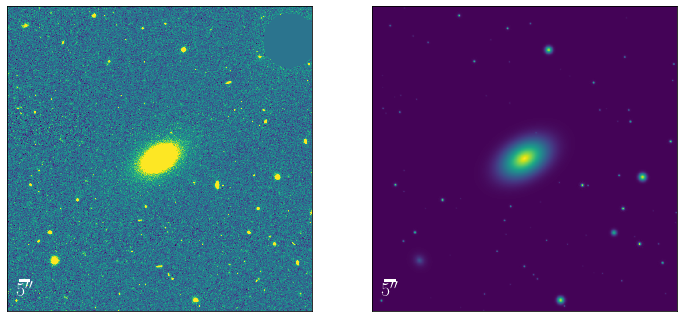

In [215]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
ax1 = display_single(img_masked, ax=ax1)
ax2 = display_single(trac_mod, ax=ax2, scale='linear')

In [216]:
## Freeze the shapes of those bleeding stars
## Parameters are: pos, shape, brightness
for obj in bleed_ind:
    trac_obj.catalog[obj].shape.freezeParam('ab')
    trac_obj.catalog[obj].shape.freezeParam('phi')

In [217]:
%%time

trac_obj.freezeParam('images')
#trac_obj.thawParam('images')
#trac_obj.optimize_loop()
for i in range(10):
    dlnp, X, alpha = trac_obj.optimize()
    print ('dlnp', dlnp)
    if dlnp < 10000:
        break

dlnp 356039911.11144984
dlnp 117206764.6031875
dlnp 0
CPU times: user 7.88 s, sys: 2.37 s, total: 10.2 s
Wall time: 3.13 s


In [218]:
trac_mod_opt_nocen = trac_obj.getModelImage(0, minsb=0., srcs=nocen_sources)
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

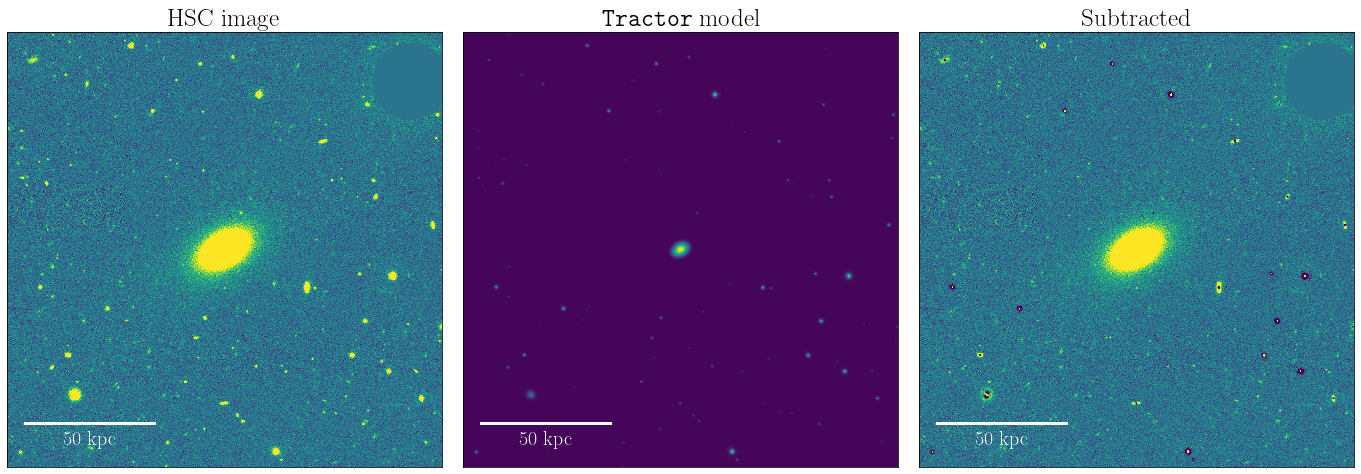

In [219]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(19,8))
ax1 = display_single(img_masked, ax=ax1, 
                     scale_bar=True, scale_bar_length=50, physical_scale=True)
ax1.set_title(r'$\mathrm{HSC\ image}$', fontsize=25)
ax2 = display_single(trac_mod_opt, ax=ax2, scale='linear',
                     scale_bar=True, scale_bar_length=50, physical_scale=True, contrast=0.03)
ax2.set_title(r'$\texttt{Tractor}\mathrm{\ model}$', fontsize=25)
ax3 = display_single(img_masked - trac_mod_opt_nocen, ax=ax3, 
                     scale_bar=True, scale_bar_length=50, physical_scale=True, contrast=0.16)
ax3.set_title(r'$\mathrm{Subtracted}$', fontsize=25)
plt.subplots_adjust(wspace=0.0, left=0.0, right=1.0)
#plt.savefig('tractor_demo.png', bbox_inches='tight', dpi=100)

### Save tractor image

In [220]:
img_fits = './img_tractor.fits'

_ = io.save_to_fits(img_masked - trac_mod_opt_nocen, img_fits)